The purpose of this notebook is to analyze spec2vec mass spectral embeddings using PCA, t-SNE and UMAP.
It has several parts.

1) Post process "raw" spectra with matchms.

2) Creating a subset of the imported dataset, based on how many times a certain InChIkey occurs in the dataset.

3) Performing dimension reduction techniques and plotting, categorizing on InChIkeys or compound names

4) Performing dimension reduction techniques and plotting, categorizing based on classification (superclass/class/subclass)

First, define the path to the data folder:

In [3]:
import os
import sys
import gensim
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

ROOT = os.path.dirname(os.getcwd())
path_data = '/mnt/scratch/rebac002/data/AllPositive2'
sys.path.insert(0, ROOT)

Picking the correct file (AllPositive2 dataset):

In [4]:
import pickle
outfile = os.path.join(path_data,'ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups.pickle')
with open(outfile, 'rb') as filename:
    spectrums = pickle.load(filename)

In [5]:
number_of_peaks = [len(spec.peaks) for spec in spectrums]
#plt.figure(figsize=(12,7))
#hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
#plt.xlabel("number of peaks in spectrum")
#plt.ylabel("number of spectra in respective bin")

**Post-processing for Spec2Vec**

Spec2Vec similarity scores rely on creating a document vector for each spectrum. For the underlying word2vec model we want the documents (=spectra) to be more homogeneous in their number of unique words. Assuming that larger compounds will on average break down into a higher number of meaningful fragment peaks we reduce the document size of each spectrum according to its parent mass.

-normalize peaks (maximum intensity to 1)
-remove peaks outside [0, 1000] m/z window
-remove spectra with < 10 peaks
-reduce number of peaks to maximum of 0.5 * parent mass
-remove peaks with intensities < 0.001 of maximum intensity (unless this brings number of peaks to less than 10)

In [6]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import add_losses


def post_process_s2v(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    if s is None:
        return None
    s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.001)
    if len(s_remove_low_peaks.peaks) >= 10:
        s = s_remove_low_peaks
        
    s = add_losses(s, loss_mz_from=5.0, loss_mz_to=200.0)
    return s

# apply post processing steps to the data
spectrums_s2v = [post_process_s2v(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums_s2v = [s for s in spectrums_s2v if s is not None]

print("{} remaining spectra.".format(len(spectrums_s2v)))

115388 remaining spectra.


In [7]:
pickle.dump(spectrums_s2v, 
            open(os.path.join(path_data,'ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups.pickle'), "wb"))

In [8]:
#load a pre-cleaned file(optional, can also use the spectrums_s2v from above)
outfile = os.path.join(path_data,'ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups.pickle')
with open(outfile, 'rb') as file:
    spectrums_s2v = pickle.load(file)

In [9]:
number_of_peaks = [len(spec.peaks) for spec in spectrums_s2v]
#plt.figure(figsize=(12,7))
#hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
#plt.xlabel("number of peaks in spectrum")
#plt.ylabel("number of spectra in respective bin")

**IMPORTANT!**
Here you select spectra containing inchikeys to build a pandas dataframe. Later on for classification, classes are based on an inchikey, so if there is no inchikey in the metadata of a certain spectrum, errors are likely to arise, and is the reasoning behind this.

In [10]:
Inchikeys = []
for spec in spectrums_s2v:
    Inchikeys.append(spec.get("inchikey"))

inchikeys_pd = pd.Series([x for x in Inchikeys if x]) #select spectra that DO contain inchikeys in metadata
#inchikeys_pd.str[:14].value_counts()[:20]

In [11]:
print(len(Inchikeys))
print(len(inchikeys_pd))

115388
96318


Check how complete the metadata of the spectra is:

In [12]:
spectra_with_inchikey = []
spectra_with_compound_name = []
spectra_with_inchi_name = []
for s in spectrums_s2v:
    if len(s.get("inchikey")) >= 14:
        spectra_with_inchikey.append(s)
    if len(s.get("compound_name")) > 0:
        spectra_with_compound_name.append(s)
    if len(s.get("inchikey")) >= 14 and len(s.get("compound_name")) >0:
        spectra_with_inchi_name.append(s)
    
print(len(spectra_with_inchikey)) #spectra with inchikey
print(len(spectra_with_compound_name)) #spectra with compound name
print(len(spectra_with_inchi_name)) #spectra with both inchikey and compound name

96318
114256
95186


In [13]:
#(optional)Plot inchikey occurrences
#plt.figure(figsize=(12,6))
#plt.hist(inchikeys_pd.str[:14].value_counts(), np.linspace(0, 60, 60))
#plt.xlabel('Number of occurences of inchikey')
#plt.ylabel('Number of inchikeys with respective number of occurences')

**Randomly select 1000 inchikeys that exist >=min_copies_in_data times in the dataset**

This is where the subset is made. If you want to use the whole dataset, **min_copies_in_data should** be 1, and **num_spectra** should be equal to the length of **suitable_inchikeys**

In [14]:
min_copies_in_data = 1 #min nr of spectra per inchikey

suitable_inchikeys = pd.DataFrame(inchikeys_pd.str[:14].value_counts()[inchikeys_pd.str[:14].value_counts().values >= min_copies_in_data])
suitable_inchikeys.reset_index(level=suitable_inchikeys.index.names, inplace=True)
suitable_inchikeys.columns = (['inchikey14', 'occurences'])

# Important: sort values to make it reproducible (same occurences have random order otherwise!)
suitable_inchikeys = suitable_inchikeys.sort_values(['occurences', 'inchikey14'], ascending=False)

In [15]:
print(len(suitable_inchikeys))

14488


Here, select the inchikeys:

In [16]:
num_spectra = 14488 #how many do you want to randomly select?
np.random.seed(35) # to make it reproducible

selection = np.random.choice(suitable_inchikeys.shape[0], num_spectra, replace=False)
selected_inchikeys = suitable_inchikeys['inchikey14'].values[selection]
#selected_inchikeys

In [17]:
print(len(selected_inchikeys))

14488


Now that we selcted the inchikeys, we need to trace back which spectra they represent and select those spectra:

In [18]:
selected_spectra = []
inchikeys_pd_full = pd.Series([x for x in Inchikeys]) #include all even empty ones to get the IDs right!
np.random.seed(35) # to make it reproducible
for inchikey in selected_inchikeys:
    matches = inchikeys_pd_full[inchikeys_pd_full.str[:14] == inchikey].index.values
    selected_spectra.extend(matches)

In [19]:
print(len(selected_spectra))

96318


Import model pre-trained on AllPositive2 dataset (will need it for vector calculation):

In [20]:
filename_path = "ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups_spec2vec_embedding_iter_15.model"
filename_model = os.path.join(path_data, filename_path)

pretrained_model = gensim.models.Word2Vec.load(filename_model)

In [21]:
from spec2vec import SpectrumDocument

spectrum_documents = [SpectrumDocument(s, n_decimals=2) for i, s in enumerate(spectrums_s2v) if i in selected_spectra]

The function "calc_vector" calculates only a single vector from a single document. To make it calculate all our vectors from spectrum_documents, a for loop is used. I also used a numpy array instead of a regular list to improve performance. Each "single_vector" is a list of 300 (dimensions), and there are 1313 "single_vector"s in total.

In [22]:
from typing import Union
import numba
from gensim.models.basemodel import BaseTopicModel
from spec2vec.Document import Document
from spec2vec.vector_operations import calc_vector

list_of_vectors = []
for i in spectrum_documents:
    single_vector = calc_vector(pretrained_model, i)
    list_of_vectors.append(single_vector)
    
spec_vectors = np.stack(list_of_vectors)

In [23]:
print(len(spec_vectors))

96318


Before going on to visualization, indices for the spectra will be needed. Or in other words, a list with the same length as spec_vectors, where spec_inchikeys[0] will represent the inchikey of spec_vectors[0].

In order to do this, the same order of spectra needs to be preserved as was made in spectrum_documents. So we will generate a properly ordered list of selected spectra, and retreive the inchikeys for them.

In [24]:
spec_inchikeys = [] #new list for inchikeys matching spec_vectors

for i, s in enumerate(spectrums_s2v):
    if i in selected_spectra:
        if len(s.metadata.get("inchikey"[:14])) >= 14:
            spec_inchikeys.append(s.metadata.get("inchikey")[:14])
        else:
            spec_inchikeys.append("Undefined")

In [25]:
print(len(spec_inchikeys))

96318


In [26]:
chosen_spectra = [] #list of ACTUAL spectra with metadata, not to be
                    #confused with  selected_spectra!

for i, s in enumerate(spectrums_s2v):
    if i in selected_spectra:
        chosen_spectra.append(s)

In [27]:
print(len(chosen_spectra))

96318


We will also make a list like that for compound names, ready to use as an index:

In [28]:
#first create a dictionary of inchikeys as keys and names as values
inchikey_name_dict = {}
for i, s in enumerate(spectrums_s2v):
    if i in selected_spectra:
        inchikey = s.get("inchikey")
        if len(inchikey) >= 14:
            inchikey = inchikey[:14]
        else:
            inchikey = "Undefined"
        name = s.get("compound_name")
        if len(name) == 0:
            name = "Undefined"
        if inchikey in inchikey_name_dict:
            inchikey_name_dict[inchikey].append(name)
        else:
            inchikey_name_dict[inchikey] = [name]

In [29]:
spec_names = []
for inchikey in spec_inchikeys:
    possible_names = inchikey_name_dict[inchikey]
    shortest_len = min([len(possible_name) for possible_name in possible_names if len(possible_name) > 0])
    shortest_name=[name for name in possible_names if len(name) == shortest_len]
    spec_names.append(shortest_name[0])

In [ ]:
print(len(spec_names))

**=========PLOT USING INCHIKEYS AS LEGEND=========**

**PCA VISUALIZATION**

In [ ]:
#Build the dataset
spec_dataset = pd.DataFrame(spec_vectors, index=spec_inchikeys,
                            columns = [str(i) for i in range(spec_vectors.shape[1])])

To plot in seaborn

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn import decomposition

#perform PCA
pca_seaborn = decomposition.PCA(n_components=3)
pca_seaborn_results = pca_seaborn.fit_transform(spec_dataset)

In [ ]:
pca_seaborn.explained_variance_ratio_

In [ ]:
#define X and Y axes
spec_dataset['PC1'] = pca_seaborn_results[:,0]
spec_dataset['PC2'] = pca_seaborn_results[:,1]

#plot
plt.figure(figsize=(15,9))
plot = sns.scatterplot(x='PC1', y='PC2',
           data=spec_dataset, palette=sns.color_palette("hls", 40),
            hue=spec_dataset.index, s=15,
            legend="full") #legend=False to disable, legend="full" to enable



plot.set(xlim=(-1000, 1700))
plot.set(ylim=(-1200, 2000))
#position the legend next to the graph; edit integers to change position
#WARNING! If the legend causes the plot to be too large, it will not be plotted!

box = plot.get_position()
plot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position
# Put a legend to the right side and determine amount of columns
nr_columns = int(len(selected_inchikeys)/40)
if nr_columns == 0:
    nr_columns += 1
anchor_x = 1 + (nr_columns*0.25)
plot.legend(loc='center right', bbox_to_anchor=(anchor_x, 0.5), ncol=nr_columns)


**t-SNE VISUALIZATION**

In [ ]:
from __future__ import print_function
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#perform tSNE
tsne_model = TSNE(n_components=2, random_state=35)
tsne_results = tsne_model.fit_transform(spec_dataset)

To plot t-SNE, I will use seaborn (sns):

In [ ]:
#create array with colors
tSNE_colors = ['#E6194B', '#3CB44B', '#FFE119', '#4363D8', '#F58231',
                '#911EB4', '#46F0F0', '#F032E6', '#BCF60C', '#FABEBE',
                '#008080', '#E6BEFF', '#9A6324', '#FFFAC8', '#800000',
                '#AAFFC3', '#808000', '#FFD8B1', '#000075', '#808080',
                '#FFFFFF', '#000000']

#set custom color palette
tSNE_palette = sns.set_palette(sns.color_palette(tSNE_colors))

In [ ]:
print(len(tsne_results))

In [ ]:
#define the x and y axes
spec_dataset['tsne-2d-one'] = tsne_results[:,0]
spec_dataset['tsne-2d-two'] = tsne_results[:,1]

#make the scatterplot using seaborn
plt.figure(figsize=(15,9)) #adjust plot size for easier interpretation
plot = sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue=spec_dataset.index,
                palette=sns.color_palette("hls", 40),
                #palette=tSNE_palette, #only use this palette if you have 20 or less categories!
                data=spec_dataset, legend="full", #disable legend if too many categories
                alpha=0.3, s=20)

plot.set(xlim=(-80, 80))
plot.set(ylim=(-100, 100))

#position the legend next to the graph; edit integers to change position
#WARNING! If the legend causes the plot to be too large, it will not be plotted!
box = plot.get_position()
plot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
plot.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)

In [ ]:
#select a specific cluster on the graph based on the x and y coordinates and save the spectra in a list
cluster_spec_list = [] #list for selected spectra

for s, coordinate in zip(chosen_spectra, pca_seaborn_results):
    if coordinate[0] > 1000 and coordinate[1] > 1000:
        cluster_spec_list.append(s)
print(len(cluster_spec_list))

In [ ]:
for i in cluster_spec_list:
    print(i.get("inchikey"))

In [ ]:
interested_cols = ["compound_name", "adduct", "instrument", "parent_mass", "inchikey", "smiles"]
info = []
for s in cluster_spec_list:
    s_info = []
    for col in interested_cols:
        s_info.append(s.metadata.get(col, ""))
        info.append(s_info)

**UMAP VISUALIZATION**

In [42]:
import umap

umap_results = umap.UMAP(random_state=35).fit_transform(spec_dataset)

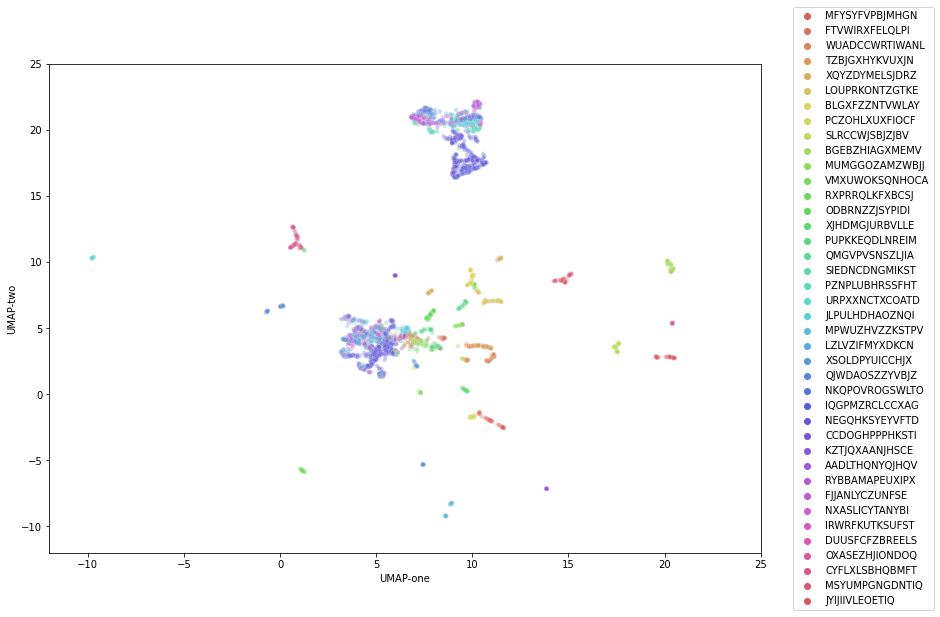

In [43]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
#define the x and y axes
spec_dataset['UMAP-one'] = umap_results[:,0]
spec_dataset['UMAP-two'] = umap_results[:,1]

#make the scatterplot using seaborn
plt.figure(figsize=(15,9)) #adjust plot size for easier interpretation
plot = sns.scatterplot(x="UMAP-one", y="UMAP-two",
                hue=spec_dataset.index,
                palette=sns.color_palette("hls", 40),
                #palette=tSNE_palette, #only use this palette if you have 20 or less categories!
                data=spec_dataset, legend="full", alpha=0.3, s=20)


plot.set(xlim=(-12, 25))
plot.set(ylim=(-12, 25))
#position the legend next to the graph; edit integers to change position
#WARNING! If the legend causes the plot to be too large, it will not be plotted!

box = plot.get_position()
plot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
plot.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)


Plot ALLEEN de inchikeys van interresse om te zien hoe ze clusteren.

In [47]:
sel_inchikey = "MFYSYFVPBJMHGN"#MPWUZHVZZKSTPV #MFYSYFVPBJMHGN #URPXXNCTXCOATD
vectors_to_plot = [] 
inchikeys_to_plot = []
tsne_plot = [] 
umap_plot = []
spectra_to_plot = []
pca_plot = []

for inchikey, vec, tsne, umap, s, pca in zip(spec_inchikeys, spec_vectors, tsne_results, umap_results, chosen_spectra, pca_seaborn_results):
    if inchikey == sel_inchikey:
        vectors_to_plot.append(vec)
        inchikeys_to_plot.append(inchikey)
        tsne_plot.append(tsne)
        umap_plot.append(umap)
        spectra_to_plot.append(s)
        pca_plot.append(pca)
        
vecs_to_plot = np.stack(vectors_to_plot)
inchis_to_plot = np.stack(inchikeys_to_plot)
tsne_to_plot = np.stack(tsne_plot)
umap_to_plot = np.stack(umap_plot)
pca_to_plot = np.stack(pca_plot)

In [48]:
print(len(vecs_to_plot))
print(len(inchis_to_plot))
print(len(tsne_to_plot))
print(len(umap_to_plot))
print(len(spectra_to_plot))
print(len(pca_to_plot))

77
77
77
77
77
77


In [49]:
testplot_dataset = pd.DataFrame(vecs_to_plot, index=inchis_to_plot,
                            columns = [str(i) for i in range(vecs_to_plot.shape[1])])

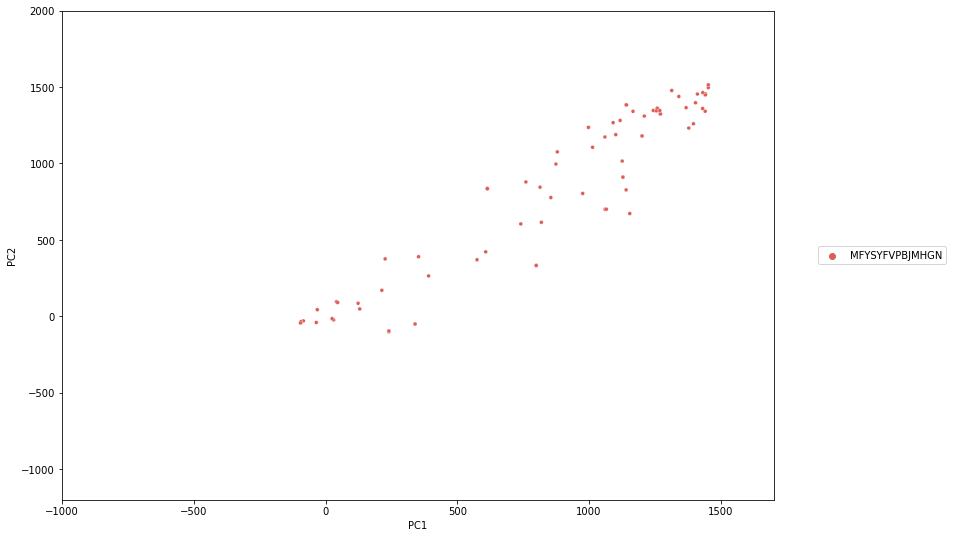

In [50]:
#define X and Y axes
testplot_dataset['PC1'] = pca_to_plot[:,0]
testplot_dataset['PC2'] = pca_to_plot[:,1]

#plot
plt.figure(figsize=(15,9))
plot = sns.scatterplot(x='PC1', y='PC2',
           data=testplot_dataset, palette=sns.color_palette("hls", 1),
            hue=testplot_dataset.index, s=15,
            legend="full") #legend=False to disable, legend="full" to enable


plot.set(xlim=(-1000, 1700))
plot.set(ylim=(-1200, 2000))

#position the legend next to the graph; edit integers to change position
#WARNING! If the legend causes the plot to be too large, it will not be plotted!

box = plot.get_position()
plot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position
# Put a legend to the right side and determine amount of columns
nr_columns = int(len(selected_inchikeys)/40)
if nr_columns == 0:
    nr_columns += 1
anchor_x = 1 + (nr_columns*0.25)
plot.legend(loc='center right', bbox_to_anchor=(anchor_x, 0.5), ncol=nr_columns)

In [68]:
pcacluster_spec_list = [] #list for selected spectra

for s, coordinate in zip(spectra_to_plot, pca_to_plot):
    if coordinate[1] > 500:
        pcacluster_spec_list.append(s)
print(len(pcacluster_spec_list))

54


In [69]:
interested_cols = ["compound_name", "adduct", "source_instrument", "parent_mass", "inchikey", "smiles"]
pca_info = []
for s in pcacluster_spec_list:
    s_info = []
    for col in interested_cols:
        s_info.append(s.metadata.get(col, ""))
    pca_info.append(s_info)

In [72]:
pca_info_index = []
for coordinates in pca_to_plot:
    if coordinates[1] > 500:
        pca_info_index.append(str(coordinates[0]) + ", " + str(coordinates[1]))

In [73]:
pca_info_df = pd.DataFrame(pca_info, index=pca_info_index,
                       columns=[col for col in interested_cols])
#pca_info_df.to_csv("PCAInfo_df_40x40_MFYSYFVPBJMHGN_2.csv")

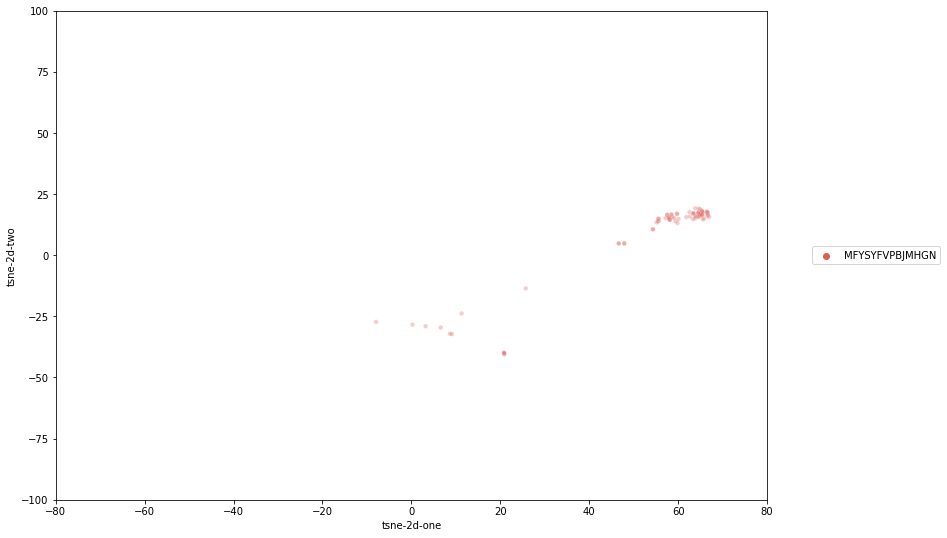

In [55]:
#define the x and y axes
testplot_dataset['tsne-2d-one'] = tsne_to_plot[:,0]
testplot_dataset['tsne-2d-two'] = tsne_to_plot[:,1]

#make the scatterplot using seaborn
plt.figure(figsize=(15,9)) #adjust plot size for easier interpretation
plot = sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue=testplot_dataset.index,
                palette=sns.color_palette("hls", 1),
                #palette=tSNE_palette, #only use this palette if you have 20 or less categories!
                data=testplot_dataset, legend="full", #disable legend if too many categories
                alpha=0.3, s=20)
plot.set(xlim=(-80, 80))
plot.set(ylim=(-100, 100))

#position the legend next to the graph; edit integers to change position
#WARNING! If the legend causes the plot to be too large, it will not be plotted!
box = plot.get_position()
plot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
plot.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)

In [56]:
cluster_spec_list = [] #list for selected spectra

for s, coordinates in zip(spectra_to_plot, tsne_to_plot):
    if 61 < coordinates[0] < 80:
        cluster_spec_list.append(s)
print(len(cluster_spec_list))

37


In [57]:
interested_cols = ["compound_name", "adduct", "source_instrument", "parent_mass", "inchikey", "smiles"]
info = []
for s in cluster_spec_list:
    s_info = []
    for col in interested_cols:
        s_info.append(s.metadata.get(col, ""))
    info.append(s_info)

In [58]:
info_index = []
for coordinates in tsne_to_plot:
    if 61 < coordinates[0] < 80:
        info_index.append(str(coordinates[0]) + ", " + str(coordinates[1]))

In [59]:
info_df = pd.DataFrame(info, index=info_index,
                       columns=[col for col in interested_cols])
info_df.to_csv("tSNEInfo_df_40x40_MFYSYFVPBJMHGN_4.csv")

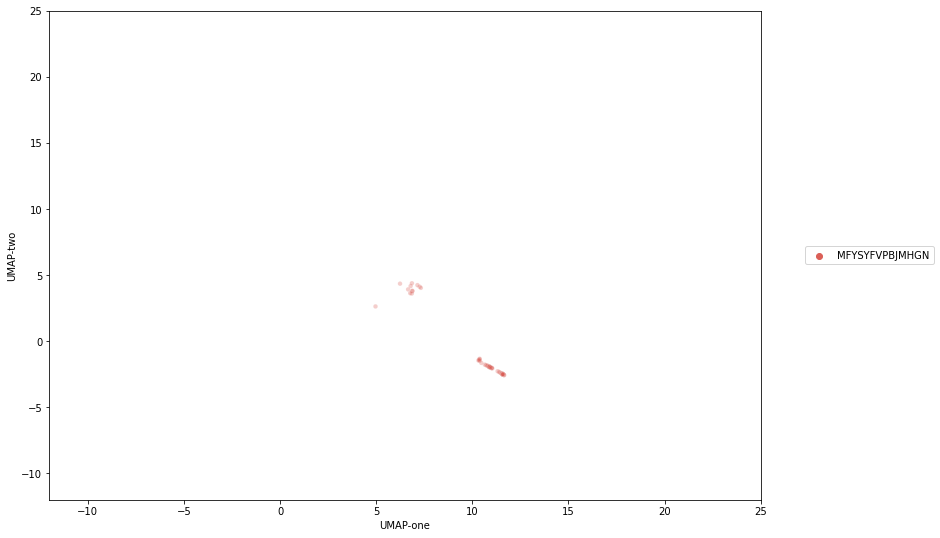

In [60]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
#define the x and y axes
testplot_dataset['UMAP-one'] = umap_to_plot[:,0]
testplot_dataset['UMAP-two'] = umap_to_plot[:,1]

#make the scatterplot using seaborn
plt.figure(figsize=(15,9)) #adjust plot size for easier interpretation
plot = sns.scatterplot(x="UMAP-one", y="UMAP-two",
                hue=testplot_dataset.index,
                palette=sns.color_palette("hls", 1),
                #palette=tSNE_palette, #only use this palette if you have 20 or less categories!
                data=testplot_dataset, legend="full", alpha=0.3, s=20)


plot.set(xlim=(-12, 25))
plot.set(ylim=(-12, 25))
#position the legend next to the graph; edit integers to change position
#WARNING! If the legend causes the plot to be too large, it will not be plotted!

box = plot.get_position()
plot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
plot.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)


In [63]:
umap_cluster_spec_list = [] #list for selected spectra

for s, coordinate in zip(spectra_to_plot, umap_to_plot):
    if 5 < coordinate[0] < 6.3:
        umap_cluster_spec_list.append(s)
print(len(umap_cluster_spec_list))

1


In [65]:
print(umap_cluster_spec_list[0].metadata)

{'pepmass': (361.201, None), 'charge': 1, 'mslevel': '2', 'source_instrument': 'ESI-Hybrid FT', 'filename': 'massbank-gnps.mgf', 'seq': '*..*', 'ionmode': 'positive', 'organism': 'MASSBANK', 'name': 'Massbank: Cortisone|(8S,9S,10R,13S,14S,17R)-17-hydroxy-17-(2-hydroxyacetyl)-10,13-dimethyl-1,2,6,7,8,9,12,14,15,16-decahydrocyclopenta[a]phenanthrene-3,11-dione M+H', 'pi': 'Massbank', 'datacollector': 'Massbank', 'smiles': 'C[C@]12CC(=O)[C@H]3[C@@H](CCC4=CC(=O)CC[C@]34C)[C@@H]1CC[C@]2(O)C(=O)CO', 'inchi': 'InChI=1S/C21H28O5/c1-19-7-5-13(23)9-12(19)3-4-14-15-6-8-21(26,17(25)11-22)20(15,2)10-16(24)18(14)19/h9,14-15,18,22,26H,3-8,10-11H2,1-2H3/t14-,15-,18+,19-,20-,21-/m0/s1', 'inchiaux': 'N/A', 'pubmed': 'N/A', 'submituser': 'mwang87', 'libraryquality': '3', 'spectrumid': 'CCMSLIB00005768751', 'scans': '43200', 'compound_name': 'Cortisone|(8S,9S,10R,13S,14S,17R)-17-hydroxy-17-(2-hydroxyacetyl)-10,13-dimethyl-1,2,6,7,8,9,12,14,15,16-decahydrocyclopenta[a]phenanthrene-3,11-dione', 'adduct': '[

In [449]:
interested_cols = ["compound_name", "adduct", "source_instrument", "parent_mass", "inchikey", "smiles"]
umap_info = []
for s in umap_cluster_spec_list:
    s_info = []
    for col in interested_cols:
        s_info.append(s.metadata.get(col, ""))
    umap_info.append(s_info)

In [450]:
umap_info_index = []
for coordinates in umap_to_plot:
    if 4 < coordinates[0] < 5:
        umap_info_index.append(str(coordinates[0]) + ", " + str(coordinates[1]))

In [452]:
info_df = pd.DataFrame(umap_info, index=umap_info_index,
                       columns=[col for col in interested_cols])
info_df.to_csv("UMAPInfo_df_40x40_MFYSYFVPBJMHGN_1.csv")

**=========PLOT USING COMPOUND NAMES AS LEGEND=========**

In [85]:
#build new dataset
names_dataset = pd.DataFrame(spec_vectors, index=spec_names,
                            columns = [str(i) for i in range(spec_vectors.shape[1])])

**PCA**

In [97]:
pca_names = decomposition.PCA(n_components=3)
pca_names_results = pca_names.fit_transform(names_dataset)

In [98]:
#define X and Y axes
names_dataset['PC1'] = pca_names_results[:,0]
names_dataset['PC2'] = pca_names_results[:,1]

"\n# Put a legend to the right side and determine amount of columns\nnr_columns = int(len(selected_inchikeys)/40)\nif nr_columns == 0:\n    nr_columns += 1\nanchor_x = 1 + (nr_columns*0.7)\nplot.legend(loc='center right', bbox_to_anchor=(anchor_x, 0.5), ncol=nr_columns)\n"

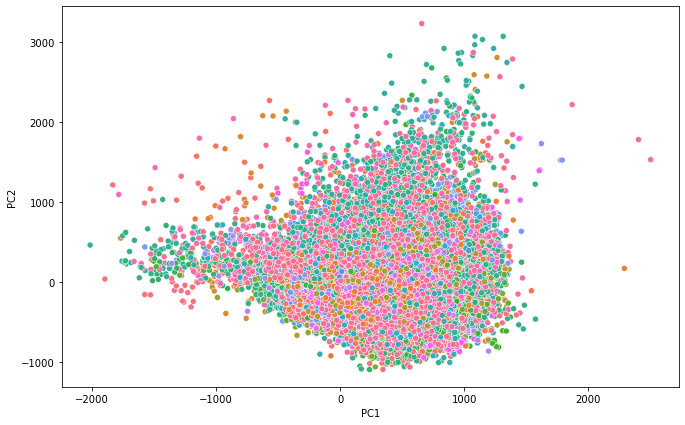

In [99]:
#plot
plt.figure(figsize=(13,7))
plot = sns.scatterplot(x='PC1', y='PC2',
           data=names_dataset, hue=names_dataset.index, legend=False)
box = plot.get_position()
plot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

#position the legend next to the graph; edit integers to change position
#WARNING! If the legend causes the plot to be too large, it will not be plotted!
'''
# Put a legend to the right side and determine amount of columns
nr_columns = int(len(selected_inchikeys)/40)
if nr_columns == 0:
    nr_columns += 1
anchor_x = 1 + (nr_columns*0.7)
plot.legend(loc='center right', bbox_to_anchor=(anchor_x, 0.5), ncol=nr_columns)
'''

**t-SNE**

In [100]:
tsne_names = TSNE(n_components=2)
tsne_names_results = tsne_names.fit_transform(names_dataset)

"\nbox = plot.get_position()\nplot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position\n\nnr_columns = int(len(selected_inchikeys)/40)\nif nr_columns == 0:\n    nr_columns += 1\nanchor_x = 1 + (nr_columns*0.7)\nplot.legend(loc='center right', bbox_to_anchor=(anchor_x, 0.5), ncol=nr_columns)\n"

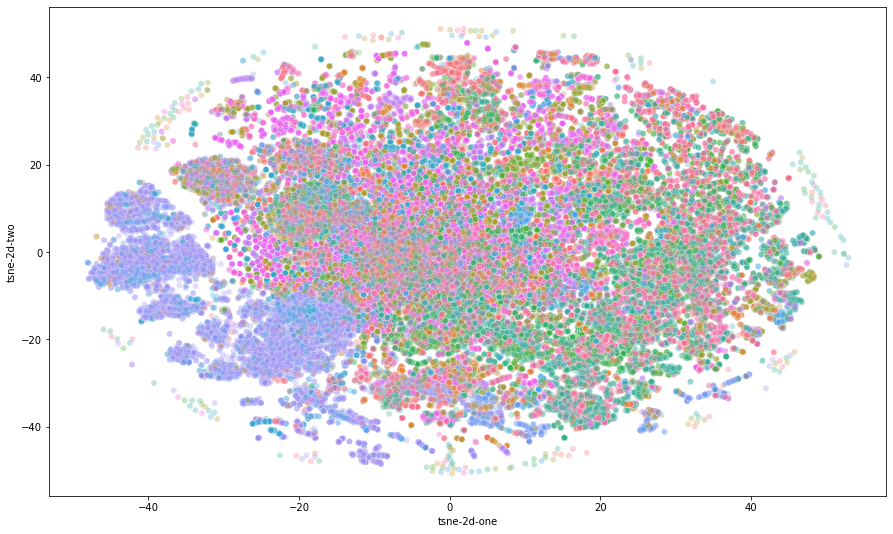

In [101]:
names_dataset['tsne-2d-one'] = tsne_names_results[:,0]
names_dataset['tsne-2d-two'] = tsne_names_results[:,1]

#make the scatterplot using seaborn
plt.figure(figsize=(15,9)) #adjust plot size for easier interpretation
plot = sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue=names_dataset.index,
                #palette=tSNE_palette,
                data=names_dataset, legend=False, alpha=0.3)

#position the legend next to the graph; edit integers to change position
#WARNING! If the legend causes the plot to be too large, it will not be plotted!
'''
box = plot.get_position()
plot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

nr_columns = int(len(selected_inchikeys)/40)
if nr_columns == 0:
    nr_columns += 1
anchor_x = 1 + (nr_columns*0.7)
plot.legend(loc='center right', bbox_to_anchor=(anchor_x, 0.5), ncol=nr_columns)
'''

**UMAP**

In [ ]:
import umap

umap_names_results = umap.UMAP().fit_transform(names_dataset)

"\nbox = plot.get_position()\nplot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position\nnr_columns = int(len(selected_inchikeys)/40)\nif nr_columns == 0:\n    nr_columns += 1\nanchor_x = 1 + (nr_columns*0.7)\nplot.legend(loc='center right', bbox_to_anchor=(anchor_x, 0.5), ncol=nr_columns)\n"

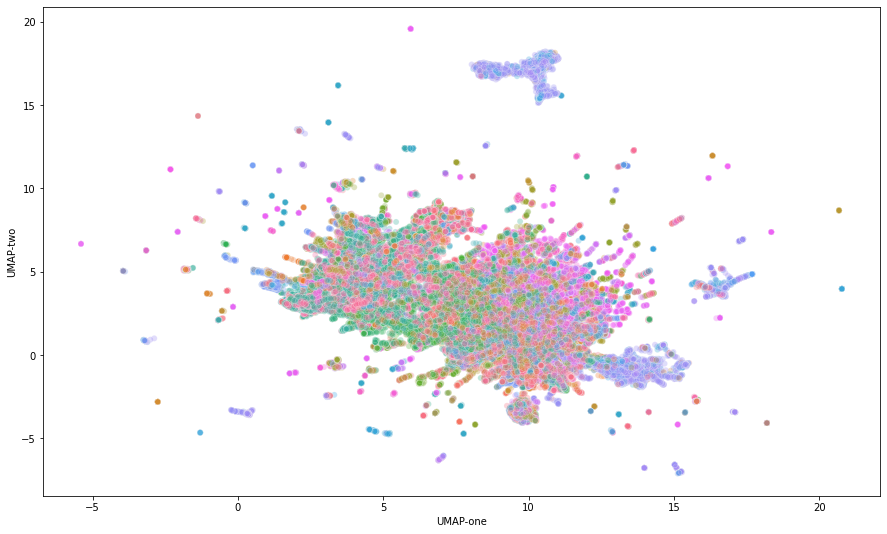

In [103]:
#define the x and y axes
names_dataset['UMAP-one'] = umap_names_results[:,0]
names_dataset['UMAP-two'] = umap_names_results[:,1]

#make the scatterplot using seaborn
plt.figure(figsize=(15,9)) #adjust plot size for easier interpretation
plot = sns.scatterplot(x="UMAP-one", y="UMAP-two",
                hue=names_dataset.index,
                palette=tSNE_palette,
                data=names_dataset, legend=False, alpha=0.3)

#position the legend next to the graph; edit integers to change position
#WARNING! If the legend causes the plot to be too large, it will not be plotted!
'''
box = plot.get_position()
plot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position
nr_columns = int(len(selected_inchikeys)/40)
if nr_columns == 0:
    nr_columns += 1
anchor_x = 1 + (nr_columns*0.7)
plot.legend(loc='center right', bbox_to_anchor=(anchor_x, 0.5), ncol=nr_columns)
'''

**=============================================CLASSIFICATION=============================================**

This will require a tab-delimited text file containing inchikeys(full, not inchikey14), smiles, and various phylogenic information (superclass, class, subclass etc.) generated by the get_classes_for_spectra.py.

That file first needs to be parsed to extract only the wanted info, which in this case is superclass, class and subclass. Then, we can use that information to plot it again.

In [30]:
#make list of sorted inchikeys for our subset
sorted_inchikeys = []
for s in chosen_spectra:
    if len(s.get("inchikey")) >= 14:
        sorted_inchikeys.append(s.get("inchikey")[:14])

In [31]:
print(len(sorted_inchikeys))

96318


In [32]:
print(sorted_inchikeys[0:10])

['IYDKWWDUBYWQGF', 'KNGPFNUOXXLKCN', 'WXDBUBIFYCCNLE', 'CGZKSPLDUIRCIO', 'USXIYWCPCGVOKF', 'WCNJVJCYRBJSLC', 'USXIYWCPCGVOKF', 'WCNJVJCYRBJSLC', 'USXIYWCPCGVOKF', 'NAIKIJSSBJHCBL']


Make a dictionary with inchikeys as keys, and classification information stored as elements of a list for each key. This will be used to easily connect inchikey to superclass/class/subclass for later analysis.

In [38]:
#open and parse the tab-delimited classification file
import re
class_infile = os.path.join(path_data,'ALL_GNPS_210409_positive_processed_annotated_CF_NPC_classes.txt')
inchi_classes_dict = {} #make dict to store values of interest
with open(class_infile, 'r') as infile:
    for line in infile:
        line = line.strip()
        line = line.split("\t")
        for inchikey in sorted_inchikeys:
            if line[0][:14] == inchikey:
                inchi_classes_dict[inchikey] = []
                if re.match('^\w', line[3]):
                    inchi_classes_dict[inchikey].append(line[3]) #CF_superclass
                else:
                    inchi_classes_dict[inchikey].append("Unclassified") 
                if re.match('^\w', line[4]):
                    inchi_classes_dict[inchikey].append(line[4]) #CF_class
                else:
                    inchi_classes_dict[inchikey].append("Unclassified") 
                if re.match('^\w', line[5]):
                    inchi_classes_dict[inchikey].append(line[5]) #CF_subclass
                else:
                    inchi_classes_dict[inchikey].append("Unclassified")
                if re.match('^\w', line[9]):
                    inchi_classes_dict[inchikey].append(line[9]) #NPC_pathway_results
                else:
                    inchi_classes_dict[inchikey].append("Unclassified")
                if re.match('^\w', line[8]):
                    inchi_classes_dict[inchikey].append(line[8]) #NPC_superclass
                else:
                    inchi_classes_dict[inchikey].append("Unclassified") 
                if re.match('^\w', line[7]):
                    inchi_classes_dict[inchikey].append(line[7]) #NPC_class
                else:
                    inchi_classes_dict[inchikey].append("Unclassified") 
                

Now, to make a sorted list of superclass/class/subclass (depending on user choice) to use as index in the database.
The choices are:

**superclass** -> classyfire superclasses

**class** -> classyfire classes

**subclass** -> classyfire subclasses

**np_pathway** -> npclassifier pathway_results

**np_superclass** -> npclassifier superclass

**np_class** -> npclassifier class

In [69]:
user_choice = "np_pathway" #edit choice to pick which function to use
if user_choice == "superclass":
    selecter = 0
if user_choice == "class":
    selecter = 1
if user_choice == "subclass":
    selecter = 2
if user_choice == "np_pathway":
    selecter = 3
if user_choice == "np_superclass":
    selecter = 4
if user_choice == "np_class":
    selecter = 5
index_list = [] #new list that will store values to use as index for plotting
for inchikey in sorted_inchikeys:
    #if inchikey in inchi_classes_dict:
        #index_list.append(inchi_classes_dict[inchikey][selecter])
    unclassified_classes = ["Unclassified", "Unclassified", "Unclassified", "Unclassified", "Unclassified", "Unclassified"]
    class_list = inchi_classes_dict.get(inchikey, unclassified_classes)
    class_ = class_list[selecter]
    index_list.append(class_)

    #for key, value in inchi_classes_dict.items():
        #if key == inchikey:
            #index_list.append(value[selecter])

In [70]:
print(len(index_list))

96318


In [71]:
print(index_list[0:10])

['Amino acids and Peptides', 'Amino acids and Peptides', 'Amino acids and Peptides', 'Shikimates and Phenylpropanoids', 'Amino acids and Peptides; Polyketides', 'Amino acids and Peptides', 'Amino acids and Peptides; Polyketides', 'Amino acids and Peptides', 'Amino acids and Peptides; Polyketides', 'Amino acids and Peptides; Polyketides']


**Plot the superclasses**

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn import decomposition

plot_dataset = pd.DataFrame(spec_vectors, index=index_list,
                            columns = [str(i) for i in range(spec_vectors.shape[1])])

In [73]:
pca_classes = decomposition.PCA(n_components=3)
pca_classes_results = pca_classes.fit_transform(plot_dataset)

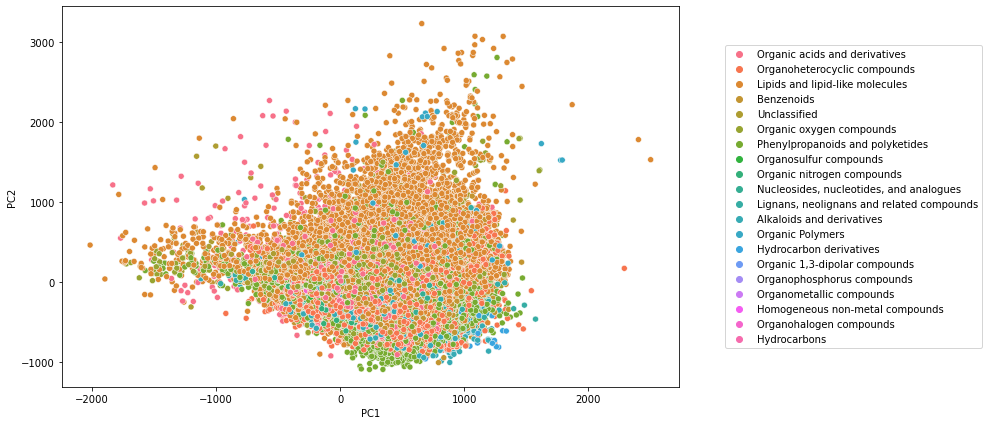

In [38]:
#define X and Y axes
plot_dataset['PC1'] = pca_classes_results[:,0]
plot_dataset['PC2'] = pca_classes_results[:,1]

#plot
plt.figure(figsize=(13,7))
plot = sns.scatterplot(x='PC1', y='PC2',
           data=plot_dataset, hue=plot_dataset.index, legend="full")

#position the legend next to the graph; edit integers to change position
#WARNING! If the legend causes the plot to be too large, it will not be plotted!
box = plot.get_position()
plot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
plot.legend(loc='center right', bbox_to_anchor=(1.50, 0.5), ncol=1)

In [74]:
from __future__ import print_function
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

tsne_classes = TSNE(n_components=2, random_state = 35)
tsne_classes_results = tsne_classes.fit_transform(plot_dataset)

In [80]:
tSNE_colors = ['#E6194B', '#3CB44B', '#FFE119', '#4363D8', '#F58231',
                '#911EB4', '#46F0F0', '#F032E6', '#BCF60C', '#FABEBE',
                '#008080', '#E6BEFF', '#9A6324', '#FFFAC8', '#800000',
                '#AAFFC3', '#808000', '#FFD8B1', '#000075', '#808080',
                '#FFFFFF', '#000000']

#set custom color palette
tSNE_palette = sns.set_palette(sns.color_palette(tSNE_colors))

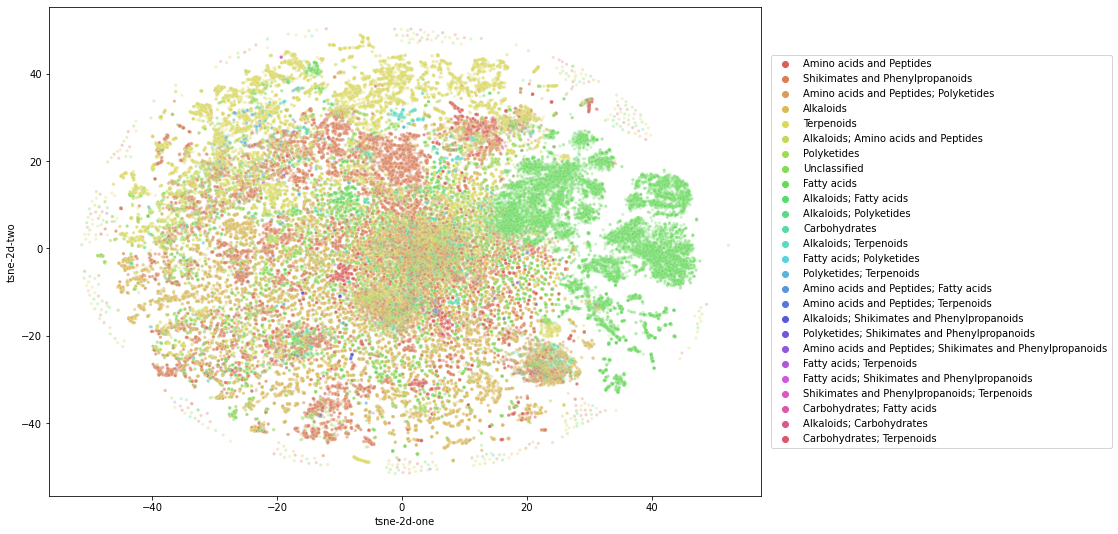

In [90]:
plot_dataset['tsne-2d-one'] = tsne_classes_results[:,0]
plot_dataset['tsne-2d-two'] = tsne_classes_results[:,1]

#make the scatterplot using seaborn
plt.figure(figsize=(15,9)) #adjust plot size for easier interpretation
plot = sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue=plot_dataset.index,
                palette=sns.color_palette("hls", 26),
                data=plot_dataset, legend="full", alpha=0.3, 
                       s=10) #adjust dot size

#position the legend next to the graph; edit integers to change position
#WARNING! If the legend causes the plot to be too large, it will not be plotted!
box = plot.get_position()
plot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
plot.legend(loc='center right', bbox_to_anchor=(1.50, 0.5), ncol=1)

In [ ]:
import umap

umap_classes_results = umap.UMAP(random_state = 35).fit_transform(plot_dataset)

In [ ]:
#define the x and y axes
plot_dataset['UMAP-one'] = umap_classes_results[:,0]
plot_dataset['UMAP-two'] = umap_classes_results[:,1]

#make the scatterplot using seaborn
plt.figure(figsize=(13,7)) #adjust plot size for easier interpretation
plot = sns.scatterplot(x="UMAP-one", y="UMAP-two",
                hue=plot_dataset.index,
                #palette=sns.color_palette("hls", 20),
                data=plot_dataset, legend="full", alpha=0.3, s=10)

#position the legend next to the graph; edit integers to change position
#WARNING! If the legend causes the plot to be too large, it will not be plotted!
box = plot.get_position()
plot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
plot.legend(loc='center right', bbox_to_anchor=(1.50, 0.5), ncol=1)

Now, we want to plot all the classes for a specific superclass, or all the subclasses for a specific class.

**PLOT ALL CLASSES FOR A SPECIFIC SUPERCLASS**

There are two ways to go about this. Either use the same t-SNE/UMAP results from before but plot only a specific class (has the advantage of preserving the same plot but only showing a certain class), or selecting a specific class and performing a completely new t-SNE/UMAP on that smaller dataset.

In this case, both methods will be used, one after another.

In [ ]:
#make a list of classes for a specific superclass
user_supercl = "Alkaloids"
classes_for_supercl = [] #list to store classes as index
cl_vectors = [] #new vector list
class_tsne = [] #new tsne results list
class_umap = [] #new umap results list

for inchikey, vec, tsne, umap in zip(sorted_inchikeys, spec_vectors, tsne_classes_results, umap_classes_results):
    if inchikey in inchi_classes_dict:
        if inchi_classes_dict[inchikey][0] == user_supercl:
            classes_for_supercl.append(inchi_classes_dict[inchikey][1])
            cl_vectors.append(vec)
            class_tsne.append(tsne)
            class_umap.append(umap)

cl_tsne = np.stack(class_tsne)
cl_vecs = np.stack(cl_vectors)
cl_umap = np.stack(class_umap)

In [97]:
print(len(classes_for_supercl))
print(len(cl_vecs))
print(len(cl_tsne))

19548
19548
19548


Plot the selected group on **old** t-SNE and UMAP results:

In [98]:
subplot_dataset = pd.DataFrame(cl_vecs, index=classes_for_supercl,
                            columns = [str(i) for i in range(cl_vecs.shape[1])])

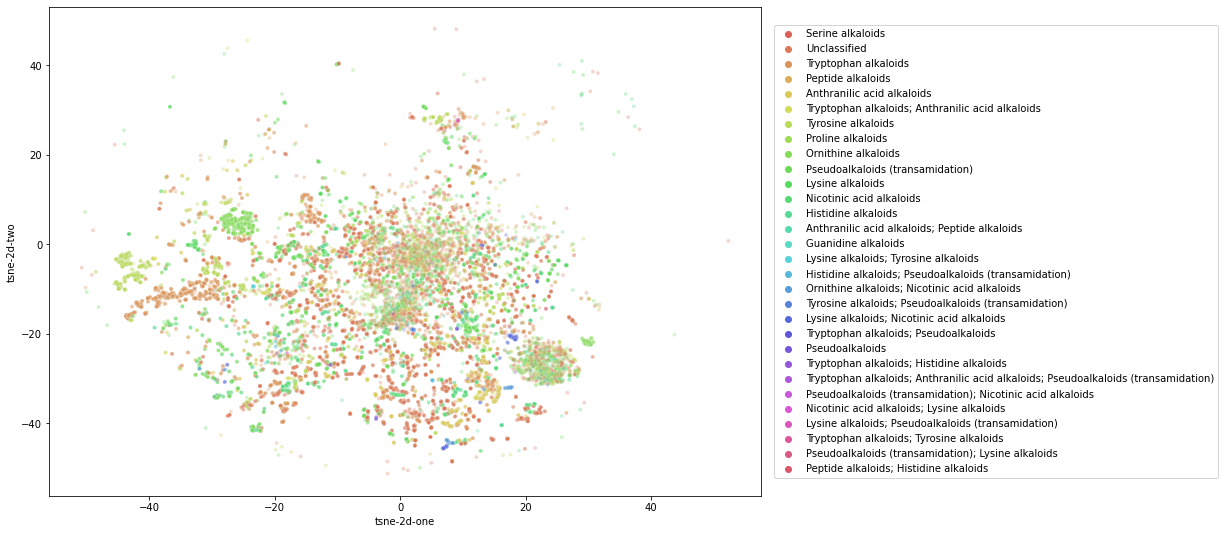

In [102]:
subplot_dataset['tsne-2d-one'] = cl_tsne[:,0]
subplot_dataset['tsne-2d-two'] = cl_tsne[:,1]

#make the scatterplot using seaborn
plt.figure(figsize=(15,9)) #adjust plot size for easier interpretation
plot = sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue=subplot_dataset.index,
                palette=sns.color_palette("hls", 30),
                data=subplot_dataset, legend="full", alpha=0.3, s=15)

#position the legend next to the graph; edit integers to change position
#WARNING! If the legend causes the plot to be too large, it will not be plotted!
box = plot.get_position()
plot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
plot.legend(loc='center right', bbox_to_anchor=(1.65, 0.5), ncol=1)

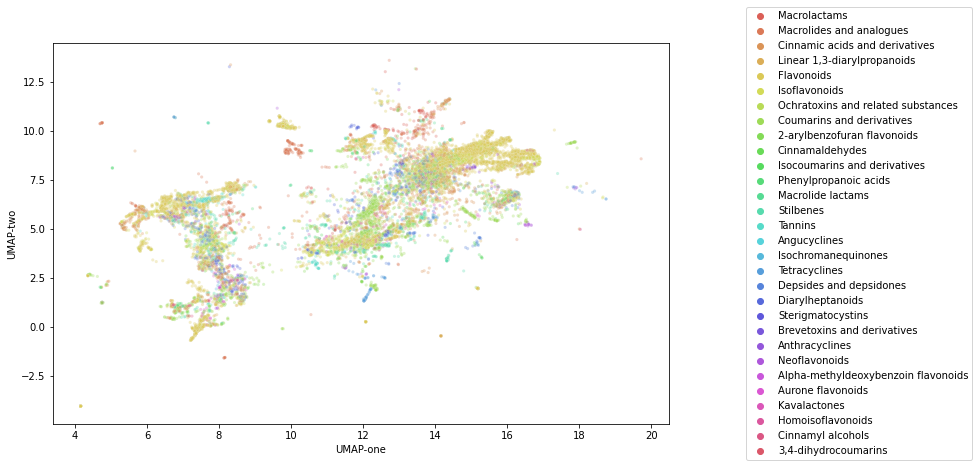

In [72]:
subplot_dataset['UMAP-one'] = cl_umap[:,0]
subplot_dataset['UMAP-two'] = cl_umap[:,1]

#make the scatterplot using seaborn
plt.figure(figsize=(13,7)) #adjust plot size for easier interpretation
plot = sns.scatterplot(x="UMAP-one", y="UMAP-two",
                hue=subplot_dataset.index,
                palette=tSNE_palette,
                data=subplot_dataset, legend="full", alpha=0.3, s=10)

#position the legend next to the graph; edit integers to change position
#WARNING! If the legend causes the plot to be too large, it will not be plotted!
box = plot.get_position()
plot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
plot.legend(loc='center right', bbox_to_anchor=(1.50, 0.5), ncol=1)

Perform and plot **new** t-SNE and UMAP:

In [103]:
#make new dataset
subplot_dataset = pd.DataFrame(cl_vecs, index=classes_for_supercl,
                            columns = [str(i) for i in range(cl_vecs.shape[1])])

In [104]:
tsne_cl = TSNE(n_components=2, random_state = 35)
tsne_cl_results = tsne_classes.fit_transform(subplot_dataset)

In [51]:
tSNE_colors = ['#E6194B', '#3CB44B', '#FFE119', '#4363D8', '#F58231',
                '#911EB4', '#46F0F0', '#F032E6', '#BCF60C', '#FABEBE',
                '#008080', '#E6BEFF', '#9A6324', '#FFFAC8', '#800000',
                '#AAFFC3', '#808000', '#FFD8B1', '#000075', '#808080',
                '#FFFFFF', '#000000']

#set custom color palette
tSNE_palette = sns.set_palette(sns.color_palette(tSNE_colors))

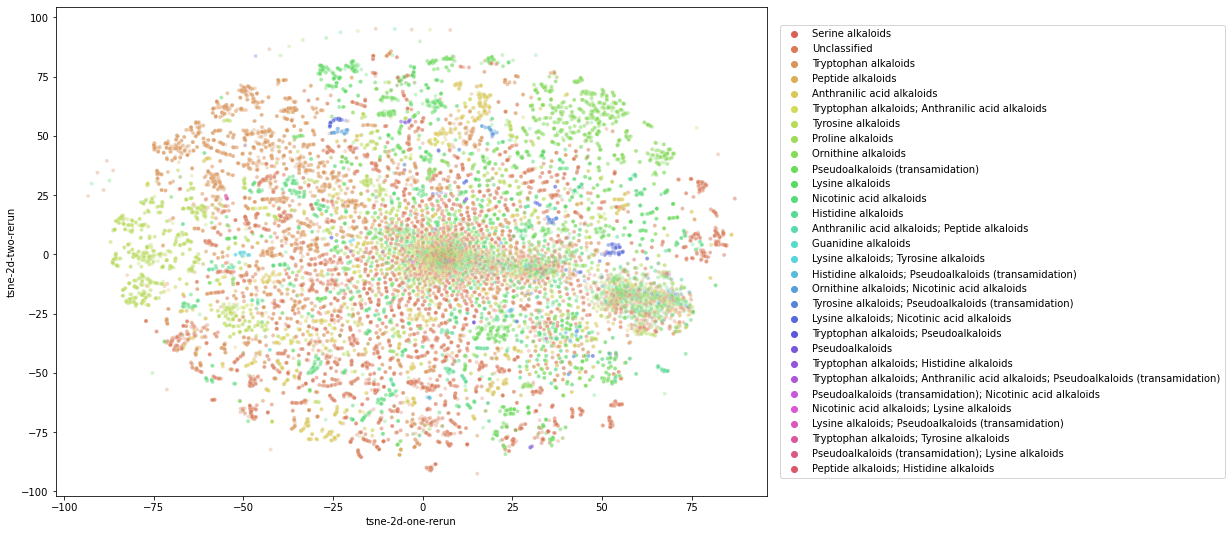

In [106]:
subplot_dataset['tsne-2d-one-rerun'] = tsne_cl_results[:,0]
subplot_dataset['tsne-2d-two-rerun'] = tsne_cl_results[:,1]

#make the scatterplot using seaborn
plt.figure(figsize=(15,9)) #adjust plot size for easier interpretation
plot = sns.scatterplot(x="tsne-2d-one-rerun", y="tsne-2d-two-rerun",
                hue=subplot_dataset.index,
                palette=sns.color_palette("hls", 30),
                data=subplot_dataset, legend="full", alpha=0.3, s=15)

#position the legend next to the graph; edit integers to change position
#WARNING! If the legend causes the plot to be too large, it will not be plotted!
box = plot.get_position()
plot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
plot.legend(loc='center right', bbox_to_anchor=(1.65, 0.5), ncol=1)

In [53]:
import umap

umap_cl_results = umap.UMAP(random_state=np.random.RandomState(35)).fit_transform(subplot_dataset)

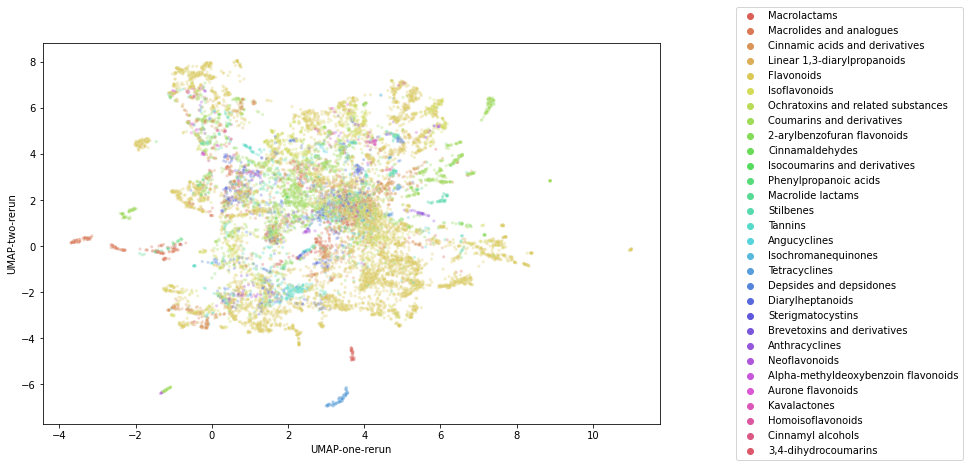

In [70]:
#define the x and y axes
subplot_dataset['UMAP-one-rerun'] = umap_cl_results[:,0]
subplot_dataset['UMAP-two-rerun'] = umap_cl_results[:,1]

#make the scatterplot using seaborn
plt.figure(figsize=(13,7)) #adjust plot size for easier interpretation
plot = sns.scatterplot(x="UMAP-one-rerun", y="UMAP-two-rerun",
                hue=subplot_dataset.index,
                palette=tSNE_palette,
                data=subplot_dataset, legend="full", alpha=0.3, s=10)

#position the legend next to the graph; edit integers to change position
#WARNING! If the legend causes the plot to be too large, it will not be plotted!
box = plot.get_position()
plot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
plot.legend(loc='center right', bbox_to_anchor=(1.50, 0.5), ncol=1)

**PLOT ALL SUBCLASSES FOR A SPECIFIC CLASS**

The same principle applies here; there are two ways to plot these.

In [55]:
#make a list of subclasses for a specific class
user_cl = "Flavonoids"
subclasses_for_cl = [] #list to store subclasses as index
scl_vectors = [] #new vector list
subclass_tsne = [] #new tsne results list
subclass_umap = [] #new umap results list

for inchikey, vec, tsne, umap in zip(sorted_inchikeys, spec_vectors, tsne_classes_results, umap_classes_results):
    if inchikey in inchi_classes_dict:
        if inchi_classes_dict[inchikey][1] == user_cl:
            subclasses_for_cl.append(inchi_classes_dict[inchikey][2])
            scl_vectors.append(vec)
            subclass_tsne.append(tsne)
            subclass_umap.append(umap)

scl_tsne = np.stack(subclass_tsne) #use this to plot without rerunning tSNE
scl_vecs = np.stack(scl_vectors)
scl_umap = np.stack(subclass_umap)

In [56]:
print(len(subclasses_for_cl))
print(len(scl_tsne))
print(len(scl_vecs))
print(len(scl_umap))

5929
5929
5929
5929


Plot the selected group on **old** t-SNE and UMAP results

In [57]:
sclplot_dataset = pd.DataFrame(scl_vecs, index=subclasses_for_cl,
                            columns = [str(i) for i in range(scl_vecs.shape[1])])

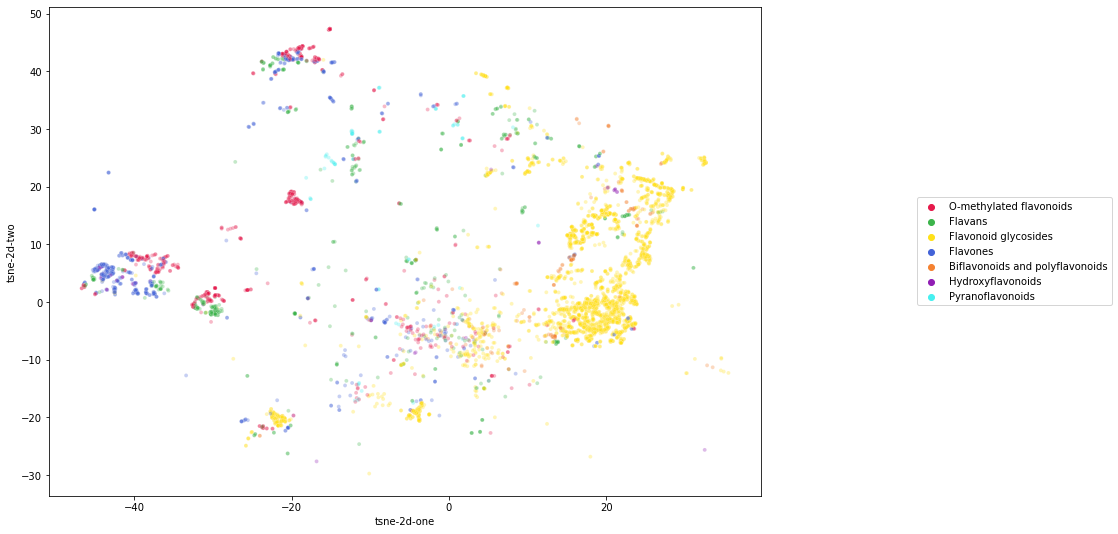

In [58]:
sclplot_dataset['tsne-2d-one'] = scl_tsne[:,0]
sclplot_dataset['tsne-2d-two'] = scl_tsne[:,1]

#make the scatterplot using seaborn
plt.figure(figsize=(15,9)) #adjust plot size for easier interpretation
plot = sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue=sclplot_dataset.index,
                palette=tSNE_palette,
                data=sclplot_dataset, legend="full", alpha=0.3, s=15)

#position the legend next to the graph; edit integers to change position
#WARNING! If the legend causes the plot to be too large, it will not be plotted!
box = plot.get_position()
plot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
plot.legend(loc='center right', bbox_to_anchor=(1.50, 0.5), ncol=1)

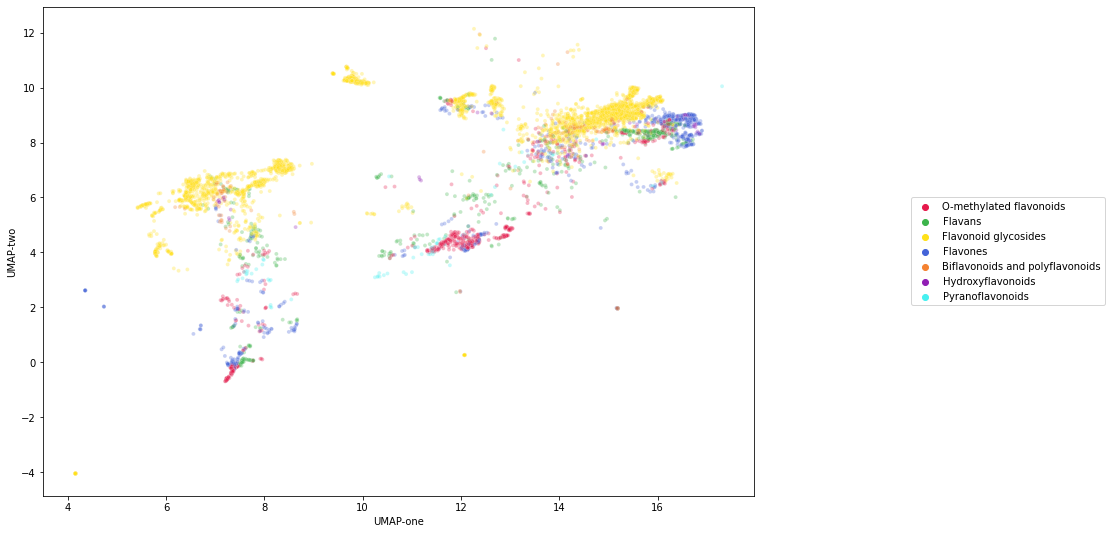

In [59]:
sclplot_dataset['UMAP-one'] = scl_umap[:,0]
sclplot_dataset['UMAP-two'] = scl_umap[:,1]

#make the scatterplot using seaborn
plt.figure(figsize=(15,9)) #adjust plot size for easier interpretation
plot = sns.scatterplot(x="UMAP-one", y="UMAP-two",
                hue=sclplot_dataset.index,
                palette=tSNE_palette,
                data=sclplot_dataset, legend="full", alpha=0.3, s=15)

box = plot.get_position()
plot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
plot.legend(loc='center right', bbox_to_anchor=(1.50, 0.5), ncol=1)

Perform and plot **new** t-SNE and UMAP

In [60]:
sclplot_dataset = pd.DataFrame(scl_vecs, index=subclasses_for_cl,
                            columns = [str(i) for i in range(scl_vecs.shape[1])])

In [61]:
tsne_scl = TSNE(n_components=2, random_state = 35)
tsne_scl_results = tsne_scl.fit_transform(sclplot_dataset)

In [62]:
tSNE_colors = ['#E6194B', '#3CB44B', '#FFE119', '#4363D8', '#F58231',
                '#911EB4', '#46F0F0', '#F032E6', '#BCF60C', '#FABEBE',
                '#008080', '#E6BEFF', '#9A6324', '#FFFAC8', '#800000',
                '#AAFFC3', '#808000', '#FFD8B1', '#000075', '#808080',
                '#FFFFFF', '#000000']

#set custom color palette
tSNE_palette = sns.set_palette(sns.color_palette(tSNE_colors))

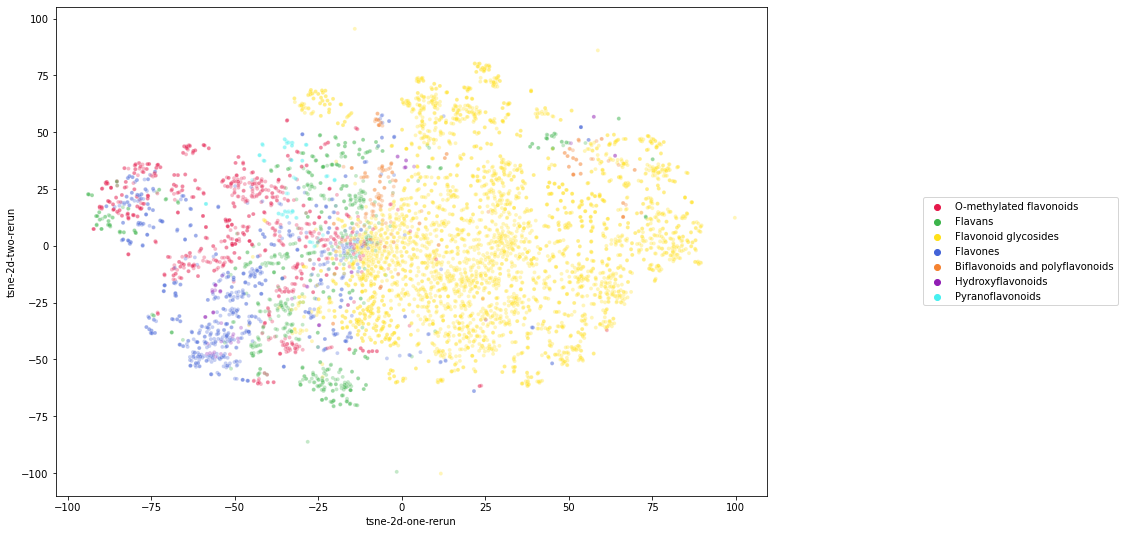

In [63]:
sclplot_dataset['tsne-2d-one-rerun'] = tsne_scl_results[:,0]
sclplot_dataset['tsne-2d-two-rerun'] = tsne_scl_results[:,1]

#make the scatterplot using seaborn
plt.figure(figsize=(15,9)) #adjust plot size for easier interpretation
plot = sns.scatterplot(x="tsne-2d-one-rerun", y="tsne-2d-two-rerun",
                hue=sclplot_dataset.index,
                palette=tSNE_palette,
                data=sclplot_dataset, legend="full", alpha=0.3, s=15)

#position the legend next to the graph; edit integers to change position
#WARNING! If the legend causes the plot to be too large, it will not be plotted!
box = plot.get_position()
plot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
plot.legend(loc='center right', bbox_to_anchor=(1.50, 0.5), ncol=1)

In [64]:
import umap

umap_scl_results = umap.UMAP(random_state=np.random.RandomState(35)).fit_transform(sclplot_dataset)

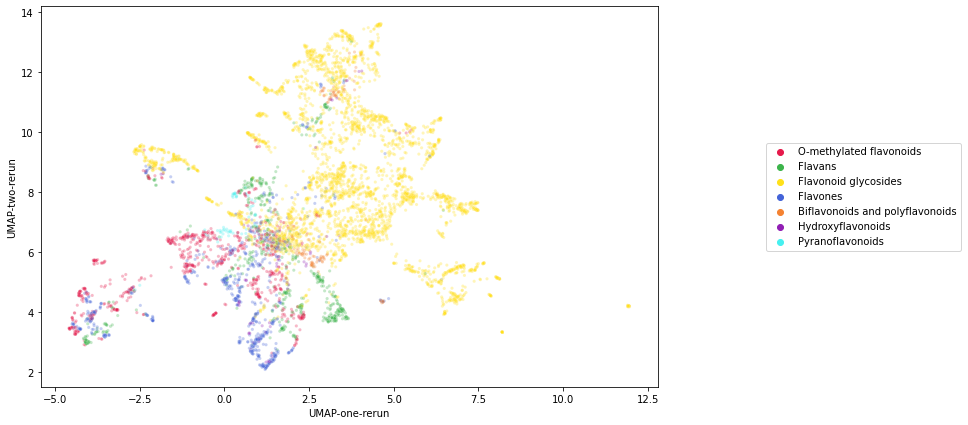

In [65]:
sclplot_dataset['UMAP-one-rerun'] = umap_scl_results[:,0]
sclplot_dataset['UMAP-two-rerun'] = umap_scl_results[:,1]

#make the scatterplot using seaborn
plt.figure(figsize=(13,7)) #adjust plot size for easier interpretation
plot = sns.scatterplot(x="UMAP-one-rerun", y="UMAP-two-rerun",
                hue=sclplot_dataset.index,
                palette=tSNE_palette,
                data=sclplot_dataset, legend="full", alpha=0.3, s=10)

#position the legend next to the graph; edit integers to change position
#WARNING! If the legend causes the plot to be too large, it will not be plotted!
box = plot.get_position()
plot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
plot.legend(loc='center right', bbox_to_anchor=(1.50, 0.5), ncol=1)

**PLOT COMPOUND NAMES FOR SPECIFIC SUBCLASS**

Finally, to get a better idea of what those subclasses actually represent, select one and plot it, categorizing by compound name.

An issue with doing this is a potentially enormous legend, since there can be hundreds, if not thousands of compound names present in a selected group. For this reason, it is advised to set **legend=False** when plotting, and setting the box part (the part of the code that determines legend position) inside triple quotes.

However, even with the legend absent, the colors will still resemble compound names so it will perhaps yield some insight into whether the spectra of the same compound cluster together.

In [80]:
#make a list of compound names for a specific subclass
user_scl = "Flavonoid glycosides"
cnames_for_scl = [] #list to store compound names as index
cpdnames_vectors = [] #new vector list
cpdnames_tsne = [] #new tsne results list
cpdnames_umap = [] #new umap results list
source_instruments = []
spec_to_plot = []
inchikey_to_plot = []

for inchikey, vec, tsne, umap, name, s in zip(sorted_inchikeys, spec_vectors, tsne_classes_results, umap_classes_results, spec_names, chosen_spectra):
    if inchikey in inchi_classes_dict:
        if inchi_classes_dict[inchikey][2] == user_scl:
            cpdnames_vectors.append(vec)
            cpdnames_tsne.append(tsne)
            cpdnames_umap.append(umap)
            cnames_for_scl.append(name)
            spec_to_plot.append(s)
            source_instruments.append(s.get("source_instrument"))
            inchikey_to_plot.append(inchikey)

cnames_tsne = np.stack(cpdnames_tsne)
cnames_umap = np.stack(cpdnames_umap)
cnames_vecs = np.stack(cpdnames_vectors)
instruments = np.stack(source_instruments)

In [81]:
print(len(cnames_tsne))
print(len(cnames_vecs))
print(len(cnames_umap))
print(len(cnames_for_scl))
print(len(instruments))
print(len(spec_to_plot))

3529
3529
3529
3529


Plot based on **old** t-SNE and UMAP

In [82]:
cnamesplot_dataset = pd.DataFrame(cnames_vecs, index=cnames_for_scl,
                            columns = [str(i) for i in range(cnames_vecs.shape[1])])

"\nbox = plot.get_position()\nplot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position\n\n# Put a legend to the right side\nplot.legend(loc='center right', bbox_to_anchor=(2.3, 0.5), ncol=1)\n"

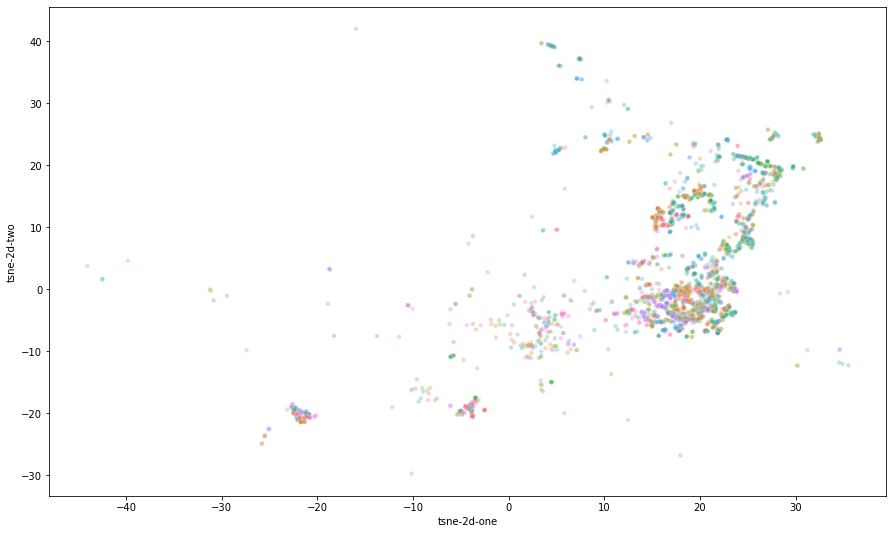

In [83]:
cnamesplot_dataset['tsne-2d-one'] = cnames_tsne[:,0]
cnamesplot_dataset['tsne-2d-two'] = cnames_tsne[:,1]

#make the scatterplot using seaborn
plt.figure(figsize=(15,9)) #adjust plot size for easier interpretation
plot = sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue=cnamesplot_dataset.index,
                #palette=sns.color_palette("hls", 29),
                data=cnamesplot_dataset, legend=False, alpha=0.3, s=20)

plot.set(xlim=(-55, 55))
plot.set(ylim=(-55, 55))

#position the legend next to the graph; edit integers to change position
#WARNING! If the legend causes the plot to be too large, it will not be plotted!

'''
box = plot.get_position()
plot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
plot.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)
'''

"\nbox = plot.get_position()\nplot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position\n\n# Put a legend to the right side\nplot.legend(loc='center right', bbox_to_anchor=(2.3, 0.5), ncol=1)\n"

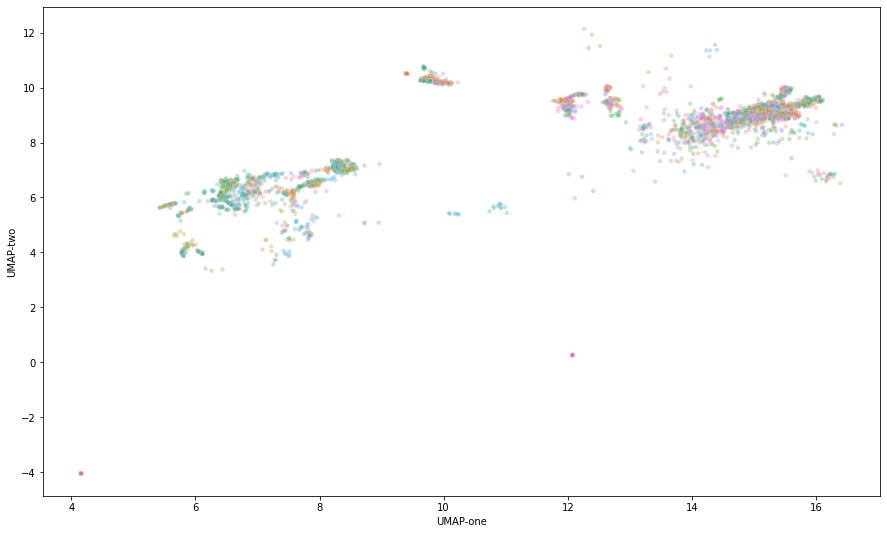

In [84]:
cnamesplot_dataset['UMAP-one'] = cnames_umap[:,0]
cnamesplot_dataset['UMAP-two'] = cnames_umap[:,1]

#make the scatterplot using seaborn
plt.figure(figsize=(15,9)) #adjust plot size for easier interpretation
plot = sns.scatterplot(x="UMAP-one", y="UMAP-two",
                hue=cnamesplot_dataset.index, data=cnamesplot_dataset,
                #palette=sns.color_palette("hls", 37),
                legend=False, alpha=0.3, s=20)

plot.set(xlim=(-6, 24))
plot.set(ylim=(-13, 18))

#position the legend next to the graph; edit integers to change position
#WARNING! If the legend causes the plot to be too large, it will not be plotted!
'''
box = plot.get_position()
plot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
plot.legend(loc='center right', bbox_to_anchor=(2.3, 0.5), ncol=1)
'''

Perform **new** t-SNE and UMAP and plot those

In [85]:
cnamesplot_dataset = pd.DataFrame(cnames_vecs, index=cnames_for_scl,
                            columns = [str(i) for i in range(cnames_vecs.shape[1])])

In [86]:
tsne_cnames = TSNE(n_components=2, random_state = 35)
tsne_cnames_results = tsne_cnames.fit_transform(cnamesplot_dataset)

"\nbox = plot.get_position()\nplot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position\n\n# Put a legend to the right side\nplot.legend(loc='center right', bbox_to_anchor=(2.3, 0.5), ncol=1)\n"

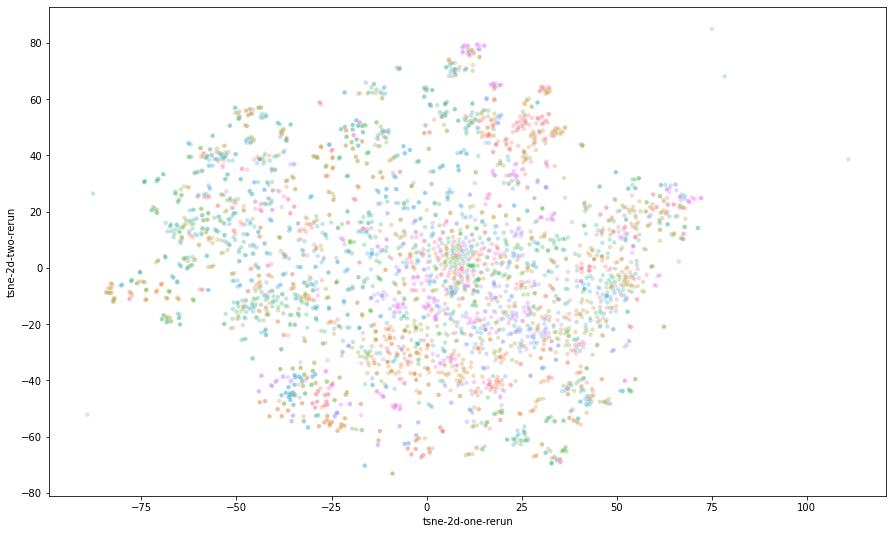

In [87]:
cnamesplot_dataset['tsne-2d-one-rerun'] = tsne_cnames_results[:,0]
cnamesplot_dataset['tsne-2d-two-rerun'] = tsne_cnames_results[:,1]

#make the scatterplot using seaborn
plt.figure(figsize=(15,9)) #adjust plot size for easier interpretation
plot = sns.scatterplot(x="tsne-2d-one-rerun", y="tsne-2d-two-rerun",
                hue=cnamesplot_dataset.index,
                #palette=sns.color_palette("hls", 37),
                data=cnamesplot_dataset, legend=False, alpha=0.3, s=20)

#position the legend next to the graph; edit integers to change position
#WARNING! If the legend causes the plot to be too large, it will not be plotted!
'''
box = plot.get_position()
plot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
plot.legend(loc='center right', bbox_to_anchor=(2.3, 0.5), ncol=1)
'''

In [ ]:
#select spectra from the plot above
tsne_sub_cluster_spec_list = [] #list for selected spectra
tsne_sub_info_index = [] #index list for the new dataset
selected_vectors = [] #list of vectors selected with the "grid" below
#if 3 < coordinate[0] < 17 and -3 < coordinate[1] < 17:
#if 8 < coordinate[0] < 14 and 71 < coordinate[1] < 85:
for s, coordinate, vec in zip(spec_to_plot, tsne_cnames_results, cnames_vecs):
    if 8 < coordinate[0] < 14 and 71 < coordinate[1] < 85:
        tsne_sub_cluster_spec_list.append(s)
        tsne_sub_info_index.append(str(coordinates[0]) + ", " + str(coordinates[1]))
        selected_vectors.append(vec)
        
sel_vecs = np.stack(selected_vectors)
print(len(tsne_sub_cluster_spec_list))
print(len(tsne_sub_info_index))
print(len(sel_vecs))

In [ ]:
interested_cols = ["compound_name", "adduct", "source_instrument", "parent_mass", "inchikey", "smiles"]
tsne_sub_info = []
for s in tsne_sub_cluster_spec_list:
    s_info = []
    for col in interested_cols:
        s_info.append(s.metadata.get(col, ""))
    tsne_sub_info.append(s_info)

In [ ]:
tsne_sub_info_df = pd.DataFrame(tsne_sub_info, index=tsne_sub_info_index,
                       columns=[col for col in interested_cols])
tsne_sub_info_df.to_csv("tSNE_flavonoid_glycosides_middle_cluster.csv")

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw

smiles_list = [] #make empty list
for s in tsne_sub_cluster_spec_list:
    smiles = s.get("smiles")
    mol = Chem.MolFromSmiles(smiles)
    smiles_list.append(mol) #append all m's to the list 'ms'
    #Draw.MolToFile(mol, f"compound_{i}.png") #write to file
    
Chem.Draw.MolsToGridImage(smiles_list) #draws all m's from the list 'ms'

In [88]:
import umap

umap_cnames_results = umap.UMAP(random_state=np.random.RandomState(35)).fit_transform(cnamesplot_dataset)

"\nbox = plot.get_position()\nplot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position\n\n# Put a legend to the right side\nplot.legend(loc='center right', bbox_to_anchor=(2.3, 0.5), ncol=1)\n"

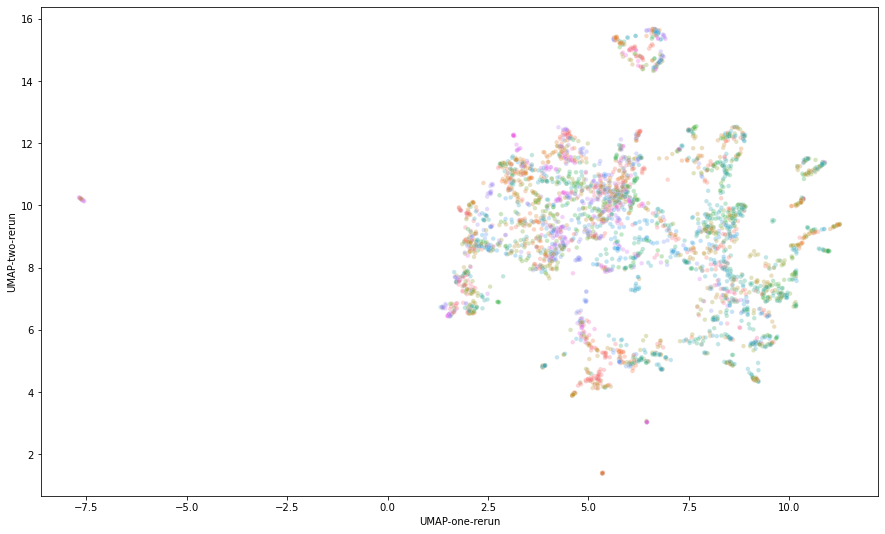

In [89]:
cnamesplot_dataset['UMAP-one-rerun'] = umap_cnames_results[:,0]
cnamesplot_dataset['UMAP-two-rerun'] = umap_cnames_results[:,1]

#make the scatterplot using seaborn
plt.figure(figsize=(15,9)) #adjust plot size for easier interpretation
plot = sns.scatterplot(x="UMAP-one-rerun", y="UMAP-two-rerun",
                hue=cnamesplot_dataset.index,
                #palette=sns.color_palette("hls", 37),
                data=cnamesplot_dataset, legend=False, alpha=0.3, s=20)



plot.set(xlim=(-6.5, 9.6))
plot.set(ylim=(1, 18))

#position the legend next to the graph; edit integers to change position
#WARNING! If the legend causes the plot to be too large, it will not be plotted!
'''
box = plot.get_position()
plot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
plot.legend(loc='center right', bbox_to_anchor=(2.3, 0.5), ncol=1)
'''

In [ ]:
umap_sub_cluster_spec_list = [] #list for selected spectra
umap_sub_info_index = []

for s, coordinate in zip(spec_to_plot, umap_cnames_results):
    if coordinate[1] > 500:
        umap_sub_cluster_spec_list.append(s)
        umap_sub_info_index.append(str(coordinates[0]) + ", " + str(coordinates[1]))
print(len(umap_sub_cluster_spec_list))

In [ ]:
interested_cols = ["compound_name", "adduct", "source_instrument", "parent_mass", "inchikey", "smiles"]
umap_sub_info = []
for s in umap_sub_cluster_spec_list:
    s_info = []
    for col in interested_cols:
        s_info.append(s.metadata.get(col, ""))
    umap_sub_info.append(s_info)

In [ ]:
umap_sub_info_df = pd.DataFrame(umap_sub_info, index=umap_sub_info_index,
                       columns=[col for col in interested_cols])
#umap_sub_info_df.to_csv("PCAInfo_df_40x40_MFYSYFVPBJMHGN_2.csv")

Check where the t-SNE selected vectors are plotted on UMAP:

In [ ]:
umap_vectors = []
umap_coordinates = []

for s, coordinate, vec, umap_coord in zip(spec_to_plot, tsne_cnames_results, cnames_vecs, umap_cnames_results):
    if 3 < coordinate[0] < 17 and -3 < coordinate[1] < 17:
        umap_vectors.append(vec)
        umap_coordinates.append(umap_coord)

umap_coords = np.stack(umap_coordinates)
umap_vecs = np.stack(umap_vectors)
print(len(umap_vecs))
print(len(umap_coords))

In [ ]:
test_dataset = pd.DataFrame(umap_vecs, index=tsne_sub_info_index,
                            columns = [str(i) for i in range(umap_vecs.shape[1])])

In [ ]:
test_dataset['UMAP-one'] = umap_coords[:,0]
test_dataset['UMAP-two'] = umap_coords[:,1]

#make the scatterplot using seaborn
plt.figure(figsize=(15,9)) #adjust plot size for easier interpretation
plot = sns.scatterplot(x="UMAP-one", y="UMAP-two",
                hue=test_dataset.index,
                #palette=sns.color_palette("hls", 37),
                data=test_dataset, legend=False, alpha=0.3, s=20)

plot.set(xlim=(-6.5, 9.6))
plot.set(ylim=(1, 18))
'''
box = plot.get_position()
plot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
plot.legend(loc='center right', bbox_to_anchor=(2.3, 0.5), ncol=1)
'''